In [1]:
from autograd import grad
import autograd.numpy as np 
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt

from sklearn import svm

import random
from sklearn import svm, datasets
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_contours(ax, clf, xx, yy, **params):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


In [3]:
def make_meshgrid(x, y, h=.02):
   
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

# (0) Writing the soft_SVM function

In [4]:
 
def soft_SVM(X1,X2,Y,lamb):
    w1 = cp.Variable() 
    w2 = cp.Variable()
    b = cp.Variable()
    samples = len(X1)
    ep = cp.Variable(samples)
    constraints = []
    
    
    for i in range(samples):
        constraints += [
        Y[i]*(w1*X1[i]+w2*X2[i]+b)+ep[i]>=1
        ]
    
  
    for i in range(samples):
        constraints += [ep[i]>=0]
        
        
    C2 = sum(ep)
    objective = cp.Minimize(w1**2 + w2**2+lamb*C2)    
    
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return constraints,w1,w2,b,ep

# (i) Autograd Gradient Computation 

In [5]:
def cost(w):
    w1 = w[0]
    w2 = w[1]
    b  = w[2]
    loss = 0
    for i, item in enumerate(Y):
        loss += max(0, 1-item*(X[i][0]*w1+X[i][1]*w2)+b)
    penalty = (0.5/C)*(w1**2+w2**2)
    return loss + penalty

In [6]:
w = np.zeros(3)
gradients = grad(cost)

In [7]:
def SVM(X,Y,num_iterations = 1000, alpha = 0.2):
    w1 = random.random()
    w2 = random.random()
    b = random.random()
    gradients = grad(cost)
    for i in range(num_iterations):
        w = np.array([w1,w2,b])
        w_grad = gradients(w)
        w1 -= alpha*w_grad[0]
        w2 -= alpha*w_grad[1]
        b -= alpha*w_grad[2]
    return w1,w2,b

In [8]:
iris = datasets.load_iris()
X = iris.data[:, :2]
Y = iris.target
C = 100
w1_ag,w2_ag,b_ag = SVM(X,Y,1000)

In [9]:
print(w1_ag,w2_ag,b_ag,"weights are incorrect")

0.03211713880918608 0.026479502583545856 -9.944448914113226 weights are incorrect


# (ii)Soft margin SVM for IRIS

In [10]:

df = pd.read_csv('iris.csv')
df = df.sample(frac = 1)
df = df.drop(['petal_length','petal_width'], axis = 1)

df['species'] = df['species'].mask(df['species'] != 'virginica',-1)
df['species'] = df['species'].mask(df['species'] == 'virginica',1)

X1 = df['sepal_length'].tolist()
X2 = df['sepal_width'].tolist()
Y = df['species'].tolist()

constraints,w1,w2,b,ep = soft_SVM(X1,X2,Y,100)

print('the parameter values are ',w1.value,' ',w2.value,' ',b.value)

the parameter values are  1.9997503571648034   1.2597060788614956e-06   -12.398503592714489


In [11]:
dual_values = []
samples = len(X1)
for i in range(samples): 
    val = constraints[i].dual_value
    if(val>0.01):
        dual_values.append(val)
    else:
        dual_values.append(0)


In [12]:
eps = ep.value
eps[eps<0.01] = 0

In [13]:
X1_v = [] 
X1_nv = [] 
X2_v = []
X2_nv = []
X1_s = []
X2_s = []


for i in range(len(X1)): 
    if(Y[i] == 1): 
        X1_v.append(X1[i])
        X2_v.append(X2[i])
       
        
    
    elif(Y[i]==-1):
        
        X1_nv.append(X1[i])
        X2_nv.append(X2[i])

    
        

# (iii) Plotting separating hyperplane for IRIS. 

Text(0, 0.5, 'sepal width')

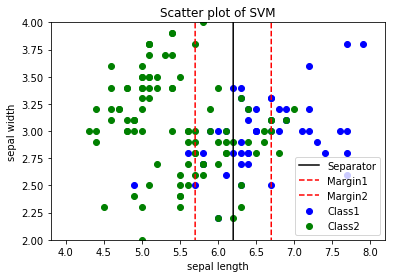

In [14]:
#Q1(b)(iii)Plotting the separating line in this case of IRIS 

fig = plt.figure()
ax = plt.axes()

x = np.linspace(4,8,100)
y = (-b.value - w1.value*x)/w2.value
y1 =(-b.value - w1.value*x-1)/w2.value
y2 =(-b.value - w1.value*x+1)/w2.value
ax.plot(x,y,linestyle = '-',color = 'black')
ax.plot(x,y1,linestyle = '--',color = 'red')
ax.plot(x,y2,linestyle = '--',color = 'red')
plt.scatter(X1_v,X2_v,color = 'blue')
plt.scatter(X1_nv,X2_nv,color = 'green')
plt.scatter(X1_s,X2_s,color = 'orange') 
plt.ylim([2,4])
plt.legend(['Separator','Margin1','Margin2', 'Class1','Class2'])
plt.title('Scatter plot of SVM')
plt.xlabel('sepal length')
plt.ylabel('sepal width')

In [15]:
#Doing the same using sklearn SVM.

df = pd.read_csv('iris.csv')
df = df.sample(frac = 1)
df = df.drop(['petal_length','petal_width'], axis = 1)

df['species'] = df['species'].mask(df['species'] != 'virginica',0)
df['species'] = df['species'].mask(df['species'] == 'virginica',1)

X = df[['sepal_length','sepal_width']].values.tolist()
Y = df['species'].values.tolist()

clf = svm.SVC(kernel = 'linear')
clf.fit(X,Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

# (iii) Plotting separating hyperplane for Sklearn SVM

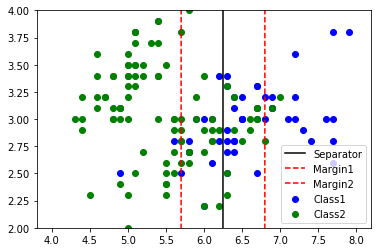

In [16]:

we1,we2 = clf.coef_[0][0],clf.coef_[0][1]
be = clf.intercept_[0]
fig = plt.figure()
ax = plt.axes()

x = np.linspace(4,8,100)
y = (-be - we1*x)/we2
y1 =(-be - we1*x-1)/we2
y2 =(-be - we1*x+1)/we2
ax.plot(x,y,linestyle = '-',color = 'black')
ax.plot(x,y1,linestyle = '--',color = 'red')
ax.plot(x,y2,linestyle = '--',color = 'red')
plt.scatter(X1_v,X2_v,color = 'blue')
plt.scatter(X1_nv,X2_nv,color = 'green')
plt.ylim([2,4])
plt.legend(['Separator','Margin1','Margin2', 'Class1','Class2'])

In [17]:
def plot_contours(ax, classifier, xx, yy, **params):
   
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# (iv) Plotting separating hyperplane for RBF and Polynomial Kernel

c:\users\abhinav\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\abhinav\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\abhinav\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", F

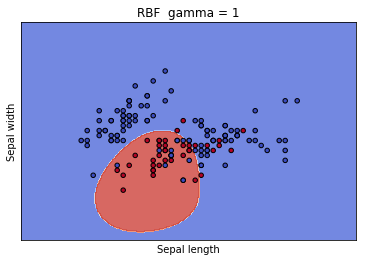

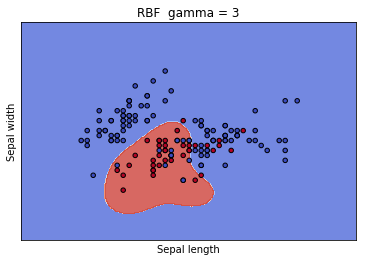

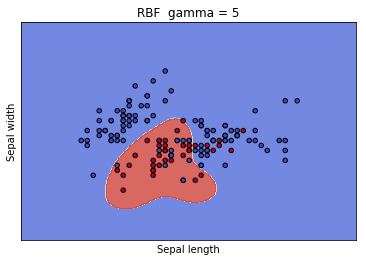

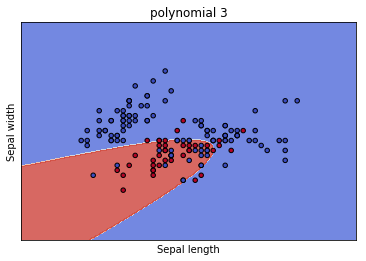

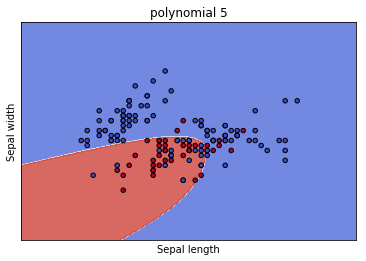

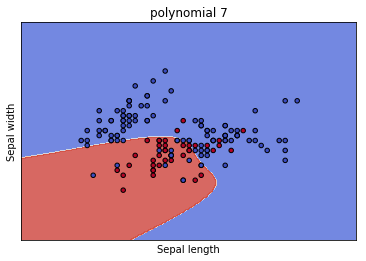

In [18]:
C = 1.0
models = (svm.SVC(kernel='rbf', gamma=1, C=C),
          svm.SVC(kernel='rbf', gamma=3, C=C),
          svm.SVC(kernel='rbf', gamma=5, C=C),
          svm.SVC(kernel='poly',degree=3, C=C),
          svm.SVC(kernel='poly',degree=5, C=C), 
          svm.SVC(kernel='poly',degree=7, C=C))

titles = ('RBF  gamma = 1',
          'RBF  gamma = 3',
          'RBF  gamma = 5',
          'polynomial 3',
          'polynomial 5',
          'polynomial 7')

models = (clf.fit(X, y) for clf in models)


iris = datasets.load_iris()
X = iris.data[:, :2]
Y = iris.target
y = []
for i in Y:
    if(i==0 or i==2):
        y.append(0)
    else: 
        y.append(1)
        



X0, X1 = X[:, 0], X[:, 1]


xx, yy = make_meshgrid(X0, X1)
for title,model in zip(titles,models):
    fig = plt.figure()
    ax  = plt.axes()
    plot_contours(ax, model, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()